## Аннотация: определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

**Цель** проекта: на основе исторических данных о технических характеристиках, комплектации и ценах автомобилей построить модель для определения рыночной стоимости транспортного средства. 

**Задача** проекта: выбрать модель, показавшую лучшие качество предсказания (оценивается с помощью метрики RMSE), скорость предсказания и время обучения.

## Знакомство с данными

In [1]:
#импортируем библиотеки и инструменты, которые понадобятся нам при выполнении проекта
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
import time

In [2]:
#применяем специальный метод для чтения файлов csv
initial_data = pd.read_csv('/datasets/autos.csv')

In [3]:
#выводим основную информацию об исходном датасете
print(initial_data.info())
print()
display(initial_data.head(10))
print()
display(initial_data.describe()) 
print()
print('Количество явных дубликатов:', initial_data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Количество явных дубликатов: 4


### Выводы:

Знакомство с данными позволило выявить следующие проблемы, требующие решения:
- некорректное название некоторых столбцов;
- наличие пропусков в части столбцов;
- наличие явных дубликатов;
- возможность отсутствия ненулевых данных в колонке с количеством изображений;
- возможное наличие выбросов в столбцах с ценой, мощностью и годом регистрации автомобиля.

На следующем этапе исследования предобработаем исходные данные для улучшения их качества.

## Предобработка данных

### Удаление дубликатов, избыточных данных и переименовывание столбцов

Начнем предобработку данных с удаления из них явных дубликатов.

In [4]:
data = initial_data.drop_duplicates().reset_index(drop=True) #удаляем дубликаты
print('Количество явных дубликатов:', data.duplicated().sum()) #проверяем результат

Количество явных дубликатов: 0


Далее переименуем столбцы согласно правилам стиля и добавим в них больше ясности и информативности.

In [5]:
data.columns = ['application_download_date', 'price', 'body_type', 'registration_year', 'gearbox_type', 'power', 
                        'model', 'mileage', 'registration_month', 'fuel_type', 'brand', 'has_been_repaired', 
                        'application_creation_date', 'number_of_pictures', 'postal_code', 'last_seen']

Посмотрим на данные в столбце number_of_pictures с целью выяснить, присутствуют ли в них ненулевые значения.

In [6]:
print(data['number_of_pictures'].unique())

[0]


Как мы видим, весь столбец заполнен нулями, а значит, мы можем его удалить. Так же не несут полезной информации сведения о последней активности пользователя сервиса, дате создания и скачивания анкеты, почтовом индексе. Их мы также удалим.

In [7]:
data = data.drop(['number_of_pictures', 'application_creation_date', 'application_download_date', 'last_seen', 'postal_code'], axis = 1)

### Исследование данных на наличие выбросов

Теперь проверим данные на выбросы, построив "ящики с усами".

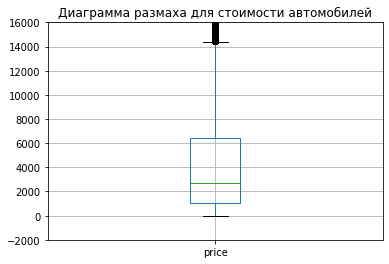

In [8]:
data.boxplot(column = 'price') #строим диаграмму размаха
plt.ylim(-2000, 16000)
plt.title('Диаграмма размаха для стоимости автомобилей')
plt.show()

В данных о стоимости автомобилей действительно присутствуют выбросы с правой стороны: их зона начинается примерно со значения в 14500 евро. Однако нулевые значения тоже вряд ли релевантны, так как пользователи прилложения хотят продать машину, а не отдать ее даром. 

Далее изучим данные о годах регистрации автомобилей.

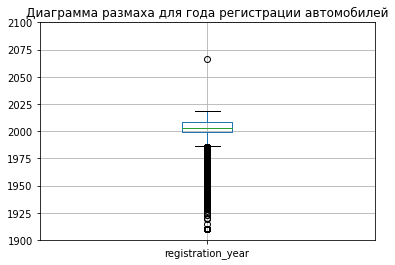

In [9]:
data.boxplot(column = 'registration_year') 
plt.ylim(1900, 2100)
plt.title('Диаграмма размаха для года регистрации автомобилей')
plt.show()

В данном случае присутствуют обе зоны выбросов. Левая начинается с 1987 года, правая с 2019. 

Наконец посмотрим на мощности представленных транспортных средств.

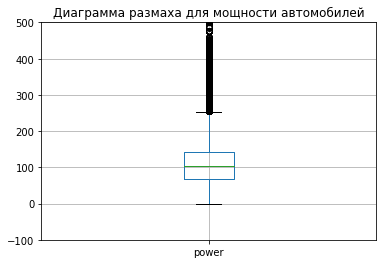

In [10]:
data.boxplot(column = 'power') 
plt.ylim(-100, 500)
plt.title('Диаграмма размаха для мощности автомобилей')
plt.show()

Здесь так же, как и в случае с ценой, одна зона выбросов и нулевые значения, от которых нужно избавиться. Правая зона выбросов начинается со значения в 250 лошадиных сил.

Очистим нашу исходную таблицу от выбросов для повышения качества и сокращения времени работы будущих моделей.

In [11]:
#очищаем данные от выбросов
data  = data.query('price < 14500 & price > 0 & registration_year < 2019 & registration_year > 1987 & power > 0 & power < 250') 

### Обработка пропусков

Перейдем к обработке пропущенных значений. Для начала нужно определить, какую долю от всех данных они занимают:

In [12]:
print(data.isna().sum().sort_values()/data.shape[0]*100)

price                  0.000000
registration_year      0.000000
power                  0.000000
mileage                0.000000
registration_month     0.000000
brand                  0.000000
gearbox_type           2.054232
model                  3.925301
fuel_type              6.698210
body_type              7.302185
has_been_repaired     15.853541
dtype: float64


Доля пропущенных значений в столбцах gearbox_type, body_type и fuel_type менее 10%, что довольно мало, поэтому можно удалить соответствующие строки без опасений, что это существенно повлияет на результаты исследования. 

Иначе дело обстоит с фактом ремонта автомобилей. В данном столбце доля пропусков выше, при этом данные могут оказать существенное влияние на стоимость автомобиля. Однако у нас нет возможности корректно заполнить пропуски, не исказив общую картину, поэтому разумнее всего будет удалить и эти строки.    

In [13]:
data = data.dropna(subset = ['gearbox_type', 'body_type', 'fuel_type', 'model', 'has_been_repaired']).reset_index(drop=True)

Посмотрим, как изменился размер нашего фрейма после всех преобразований.

In [14]:
print(initial_data.shape)
print(data.shape)

(354369, 16)
(210080, 11)


Таблица значительно уменьшилась, однако качество ее данных наоборот увеличилось за счет устранения пропусков и выбросов. 

На этом предобработку данных можно считать оконченной.

### Выводы:

На данном этапе была произведена предобработка исходных данных:
- удалены явные дубликаты;
- названия столбцов изменены согласно правилам;
- удалены столбцы с данными, которые не пригодятся для решения поставленной задачи;
- данные очищены от выбросов;
- обработаны пропущенные значения.

На следующем этапе преобразуем данные для целей машинного обучения.

## Подготовка данных к машинному обучению

Преобразуем категориальные признаки в численные, используя технику прямого кодирования (OHE). Чтобы избежать дамми-ловушки, применим аргумент drop_first.

In [24]:
data_ml = data.copy(deep=True) #дублируем предобработанный фрейм для дальнейших шагов
data_ml = pd.get_dummies(data_ml, drop_first=True) #преобразовываем категориальные признаки
display(data_ml.head(10)) # проверяем результат

,price,registration_year,power,mileage,registration_month,body_type_convertible,body_type_coupe,body_type_other,body_type_sedan,body_type_small,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,has_been_repaired_yes
0,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,3600,2008,69,90000,7,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,2200,2004,109,150000,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2000,2004,105,150000,12,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,2799,2005,140,150000,12,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
6,1750,2004,75,150000,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,7550,2007,136,150000,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1850,2004,102,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10400,2009,160,100000,4,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Далее нам нужно разбить данные на три части, получив в итоге обучающую, валидационную и тестовую выборки. Делить будем в соотношении 3:1:1, т.к. тестовая выборка "не спрятана", а также может быть выделена из исходных данных. 

Для этих целей применим дважды инструмент train_test_split. 

Данные подготовим отдельно для разных моделей: случайного леса, СatBoost и LGB.

In [15]:
#подготавливаем данные для случайного леса и LGB

#выделяем признаки и целевой признак
features = data_ml.drop(['price'], axis=1) 
target = data_ml['price'] 

#отделяем от общего объема данных тестовую выборку
features, features_test, target, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)
#делим оставшиеся данные на обучающую и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

#подготавливаем данные для CatBoost
cat_features = data.drop(['price'], axis=1) 
cat_target = data['price']
#обозначаем категориальные признаки
cat_features_categorial = ['body_type', 'gearbox_type', 'model', 'fuel_type', 'brand', 'has_been_repaired']

cat_features, cat_features_test, cat_target, cat_target_test = train_test_split(cat_features, cat_target, test_size=0.2, random_state=12345)
cat_features_train, cat_features_valid, cat_target_train, cat_target_valid = train_test_split(cat_features, cat_target, test_size=0.25, random_state=12345)

### Выводы:

На данном этапе мы подготовили предобработанные данные для дальнейшего обучения и использования моделей машинного обучения: 
- для моделей случайного леса и LGB категориальные признаки были преобразованы в числовые;
- данные разделены на обучающую, тестовую и валидационную выборки.

На следующем этапе обучим выбранные модели и проверим их работу на валидационных выборках.

## Обучение моделей

Перейдем к обучению моделей и начнем с модели случайного леса. Определим наилучшие параметры, лучшее значение метрики RMSE и время, необходимое модели для выполнения поставленных задач.

In [18]:
%%time

best_forest_model = None
best_forest_result = 10000
best_forest_estimators = 0
best_forest_depth = 0

for est in range(1, 51, 10):
    for depth in range(1, 21):
            model_forest = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
            model_forest.fit(features_train, target_train)
            predictions_valid = model_forest.predict(features_valid)
            result_forest = (mean_squared_error(target_valid, predictions_valid))**0.5
            if result_forest < best_forest_result:
                best_forest_model = model_forest
                best_forest_result = result_forest
                best_forest_estimators = est
                best_forest_depth = depth
                
print('Лучшее количество деревьев:', best_forest_estimators)
print('Лучшая глубина модели:', best_forest_depth)
print('Лучший результат случайного леса:', best_forest_result.round(3))

Лучшее количество деревьев: 41
Лучшая глубина модели: 20
Лучший результат случайного леса: 1262.471
CPU times: user 45min 31s, sys: 17.9 s, total: 45min 49s
Wall time: 45min 52s


Лучшим результатом данной модели стала RMSE = 1262.471. Данное значение было получено при глубине 20 и количестве деревьев, равном 41. Код выполнялся очень долго: почти 46 минут. Однако пока делать выводы о достоинствах и недостатках данной модели рано - нужно сравнить ее с другими.

Следующей обучим модель CatBoost:

In [19]:
%%time
cat_model = CatBoostRegressor(loss_function = "RMSE", iterations = 190, depth = 12)
cat_model.fit(cat_features_train, cat_target_train, cat_features = cat_features_categorial, verbose = 10)
pred_valid = cat_model.predict(cat_features_valid) 
cat_result = round(((mean_squared_error(cat_target_valid, pred_valid))**0.5), 3)
print(cat_result)

Learning rate set to 0.339186
0:	learn: 2738.1964894	total: 123ms	remaining: 23.3s
10:	learn: 1326.3446815	total: 1.21s	remaining: 19.8s
20:	learn: 1248.1306392	total: 2.23s	remaining: 18s
30:	learn: 1201.6582793	total: 3.25s	remaining: 16.7s
40:	learn: 1164.4591675	total: 4.26s	remaining: 15.5s
50:	learn: 1137.2709370	total: 5.3s	remaining: 14.4s
60:	learn: 1118.1208963	total: 6.33s	remaining: 13.4s
70:	learn: 1096.4955675	total: 7.39s	remaining: 12.4s
80:	learn: 1078.7225366	total: 8.39s	remaining: 11.3s
90:	learn: 1065.1259486	total: 9.4s	remaining: 10.2s
100:	learn: 1051.5162832	total: 10.4s	remaining: 9.2s
110:	learn: 1039.2943717	total: 11.4s	remaining: 8.13s
120:	learn: 1030.7670631	total: 12.5s	remaining: 7.1s
130:	learn: 1017.6952271	total: 13.5s	remaining: 6.08s
140:	learn: 1009.5560651	total: 14.5s	remaining: 5.04s
150:	learn: 998.6865280	total: 15.6s	remaining: 4.02s
160:	learn: 990.0413823	total: 16.6s	remaining: 2.99s
170:	learn: 981.1770690	total: 17.6s	remaining: 1.96s


У данной модели результаты гораздо лучше, а работает она в разы быстрее. Я пробовала разные параметры и решила остановиться на глубине 12 и количестве итераций 190, тогда RMSE будет равна 1212.575, а время выполнения 21 секунда. 

При увеличении количества итераций до 210, значение RMSE незначительно снижается до 1216.019, однако значительно вырастает время выполнения кода - более, чем в три раза - и составляет 1 минуту 3 секунды. 

Т.к. нам важен не только результат, но и время его получения, мною было принято решение остановиться на 190 итерациях.

Перейдем к модели LGB:

In [20]:
%%time

train_data = lgb.Dataset(features_train, target_train)
validation_data = lgb.Dataset(features_valid, target_valid)
params_lgb = {'objective': 'regression', 'metric': 'root_mean_squared_error'}

lgb_model = lgb.train(params_lgb, train_data, num_boost_round = 700, valid_sets = (validation_data))
lgb_predictions = lgb_model.predict(features_valid)
lgb_result = round(((mean_squared_error(target_valid, lgb_predictions))**0.5), 3)
print(lgb_result)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 126048, number of used features: 266
[LightGBM] [Info] Start training from score 4333.180392
[1]	valid_0's rmse: 3296.98
[2]	valid_0's rmse: 3068.76
[3]	valid_0's rmse: 2868.81
[4]	valid_0's rmse: 2693.16
[5]	valid_0's rmse: 2540.11
[6]	valid_0's rmse: 2406.5
[7]	valid_0's rmse: 2288.87
[8]	valid_0's rmse: 2188.21
[9]	valid_0's rmse: 2099.87
[10]	valid_0's rmse: 2021.13
[11]	valid_0's rmse: 1951.35
[12]	valid_0's rmse: 1887.83
[13]	valid_0's rmse: 1837.21
[14]	valid_0's rmse: 1790.21
[15]	valid_0's rmse: 1748.91
[16]	valid_0's rmse: 1710.6
[17]	valid_0's rmse: 1676.88
[18]	valid_0's rmse: 1644.98
[19]	valid_0's rmse: 1617.71
[20]	valid_0's rmse: 1592.7
[21]	valid_0's rmse

Данная модель незначительно уступает предыдущей по результату и времени выполнения кода. При количестве деревьев в ансамбле, равному 700, значение RMSE составило 1215.936. На выполнение кода понадобилось 29.6 секунды. 

При увеличении количества деревьев результаты модели улучшаются, однако значительно растет время работы.

### Выводы:

На данном этапе были обучены три модели машинного обучения: модель случайного леса, CatBoost и LGB, а также были подобраны параметры для кажлой модели. 


Лучшие результат и время показала модель CatBoost: RMSE = 1212.575, время выполнения 21 секунда. 

На втором месте расположилась LGB: RMSE = 1215.936, время выполнения 29.6 секунды. 

На третьем - модель случайного леса: RMSE = 1262.471, время выполнения 45 минут 52 секунды. 


На следующем этапе проверим данные модели с подобранными параметрами на тестовой выборке.

## Анализ моделей

Сравним результаты и скорость предсказания выбранных моделей на данных тестовых выборок. Проверку будем осуществлять в том же порядке, что и обучение.

In [21]:
%%time
predictions_test = best_forest_model.predict(features_test)
best_result_forest = round(((mean_squared_error(target_test, predictions_test))**0.5),3)
print(best_result_forest)

1261.466
CPU times: user 569 ms, sys: 52 ms, total: 621 ms
Wall time: 618 ms


In [22]:
%%time
pred_test = cat_model.predict(cat_features_test) 
cat_result_test = round(((mean_squared_error(cat_target_test, pred_test))**0.5), 3)
print(cat_result_test)

1226.881
CPU times: user 90.9 ms, sys: 0 ns, total: 90.9 ms
Wall time: 88.1 ms


In [23]:
%%time
lgb_predictions_test = lgb_model.predict(features_test)
lgb_best_result = round(((mean_squared_error(target_test, lgb_predictions_test))**0.5), 3)
print(lgb_best_result)

1228.72
CPU times: user 2.52 s, sys: 51.5 ms, total: 2.57 s
Wall time: 2.49 s


Наилучший результат показала модель CatBoost: у нее самое низкое значение RMSE (1226.881) и самое короткое время работы (88.1 мс). Напомним, что и на этапе обучения и проверки данная модель стала лучшей.

Напоследок изучим, какие признаки играли определяющую роли и оказывали наибольшее влияние на целевой признак. Анализ проведем на основе выбранной модели.

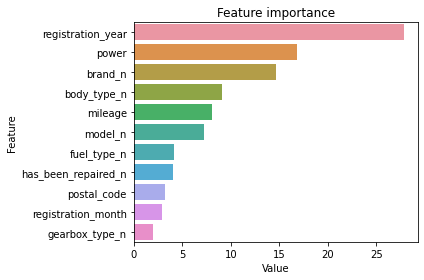

In [23]:
feature_importance = cat_model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

Как показывает график, наибольшее значение на цену автомобиля оказывает год его регистрации. Большое значение также имеют мощность и марка машины. Менее всего цена зависит от типа коробки передач.

### Выводы:

На данном этапе обученные модели были испытаны на тестовых выборках. Наилучшие результаты вновь показала модель CatBoost.
Кроме того, была изучена степень влияния признаков на значение целевого признака.

## Итоговые выводы

В ходе выполнения проекта на основе предобработанных исторических данных были обучены и протестированы три модели машинного обучения: модель случайного леса, CatBoost и LGB. В итоге была выбрана модель CatBoost, так как на каждом этапе она показала лучшие результаты по трем ключевым параметрам:
- качество предсказания;
- время обучения;
- скорость предсказания.

Таким образом, искомая модель - модель CatBoost с глубиной, равной 12, и количеством итераций, равном 190.